In [1]:
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import sqlite3                  # Общение с базой данных
import matplotlib.pyplot as plt # Научная графика
from matplotlib import ticker   # Научная графика
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения
from sklearn.preprocessing import LabelEncoder
import datetime
from tqdm import tqdm
import missingno as msno
import requests
from bs4 import BeautifulSoup as bs

In [2]:
conn = sqlite3.connect("/Users/dima/Desktop/Диплом/Data/DF_2024-05-19.db")
query = "SELECT * FROM kvartir"
data = pd.read_sql_query(query, conn)
data.replace({None: np.nan, '': np.nan}, inplace=True) # для машинного обучения
conn.close()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4422 entries, 0 to 4421
Data columns (total 55 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   index                              4422 non-null   int64  
 1   Ссылка                             4422 non-null   object 
 2   Заголовок                          4422 non-null   object 
 3   Сегмент                            4422 non-null   object 
 4   Подсегмент                         4422 non-null   object 
 5   Тип сделки                         4422 non-null   object 
 6   Цена                               4422 non-null   int64  
 7   Описание                           4262 non-null   object 
 8   Город                              4422 non-null   object 
 9   Район                              4422 non-null   object 
 10  Адрес                              4422 non-null   object 
 11  Широта                             3073 non-null   objec

# Чистка данных

**Уберем данные с арендой**

In [3]:
data = data[data['Тип сделки'].apply(lambda x: x != 'Аренда')]
data.drop(['Тип сделки'], axis=1, inplace=True)

**Удалим ненужные столбцы на глаз**

In [4]:
# data['Адрес'] = data['Город'] + ', ' + data['Адрес']
data.drop(['index', 'Заголовок', 'Сегмент', 'Подсегмент', 'Описание', 'Источник', 'Дата парсинга', 'Телефон', '№', 
           'Ссылка', 
            'Город', 'Адрес',
            'Торг уместен', 'Ипотека', 'Школа по прописке', 'ДУК и ТСЖ', 'Средняя цена за м2'], axis=1, inplace=True)

# Подчищаем что-то за парсером

In [5]:
def find_year(text):
    for word in str(text).split():
        if word.isdigit() and len(word) == 4:
            return int(word)
    return np.nan  # Возвращаем nan, если число не найдено

def calculate_age(row):
    tmp1 = find_year(row['Срок сдачи'])
    tmp2 = float(row['Год постройки'])
    year = np.nanmean([tmp1, tmp2])
    if not np.isnan(year):
        return int(year)
    else: 
        return np.nan

data['Год постройки'] = data.apply(calculate_age, axis=1)
data.drop(['Срок сдачи'], axis=1, inplace=True)

/var/folders/xz/17m9tm0x2lg28xndlr4hfm480000gp/T/ipykernel_2385/952460721.py:10: RuntimeWarning: Mean of empty slice
  year = np.nanmean([tmp1, tmp2])


In [6]:
data['Балкон'] = (data['Балкон'].fillna(0).astype(float) + data['Лоджия'].fillna(0).astype(float))
data['Балкон'] = data['Балкон'].replace({0: np.nan})

In [7]:
data['Тип жилья'] = data['Тип жилья'].replace('другой', np.nan)

In [8]:
data['Широта'] = data['Широта'].str.replace(',', '').astype(float)
data['Долгота'] =data['Долгота'].astype(float)

In [9]:
data.replace('Магазины(расстояние в метрах)', {'в здании': 0}, inplace=True)
data['До магазина (в мин.)'] = data['Магазины(расстояние в метрах)'].astype(float) / (5 * 1000 / 60)
data.drop(columns=['Магазины(расстояние в метрах)'], axis=1, inplace=True)

data.replace('Почта(расстояние в метрах)', {'в здании': 0}, inplace=True)
data['До почты (в мин.)'] = data['Почта(расстояние в метрах)'].astype(float) / (5 * 1000 / 60)
data.drop(columns=['Почта(расстояние в метрах)'], axis=1, inplace=True)

data.replace('Школы(расстояние в метрах)', {'в здании': 0}, inplace=True)
data['До школы (в мин.)'] = data['Школы(расстояние в метрах)'].astype(float) / (5 * 1000 / 60)
data.drop(columns=['Школы(расстояние в метрах)'], axis=1, inplace=True)

data.replace('Детские сады(расстояние в метрах)', {'в здании': 0}, inplace=True)
data['До детсада (в мин.)'] = data['Детские сады(расстояние в метрах)'].astype(float) / (5 * 1000 / 60)
data.drop(columns=['Детские сады(расстояние в метрах)'], axis=1, inplace=True)

data.replace('Медицина(расстояние в метрах)', {'в здании': 0}, inplace=True)
data['Медицина (в мин.)'] = data['Медицина(расстояние в метрах)'].astype(float) / (5 * 1000 / 60)
data.drop(columns=['Медицина(расстояние в метрах)'], axis=1, inplace=True)

In [10]:
# # Список столбцов в нужном порядке
# fixed_columns = ['Цена', 'Общая площадь', 'Год постройки', 'Широта', 'Долгота', 'Этажность']

# # Определяем оставшиеся столбцы
# remaining_columns = [col for col in data.columns if col not in fixed_columns]

# # Объединяем списки
# new_order = fixed_columns + remaining_columns

# # Переставляем столбцы в DataFrame
# data = data[new_order]

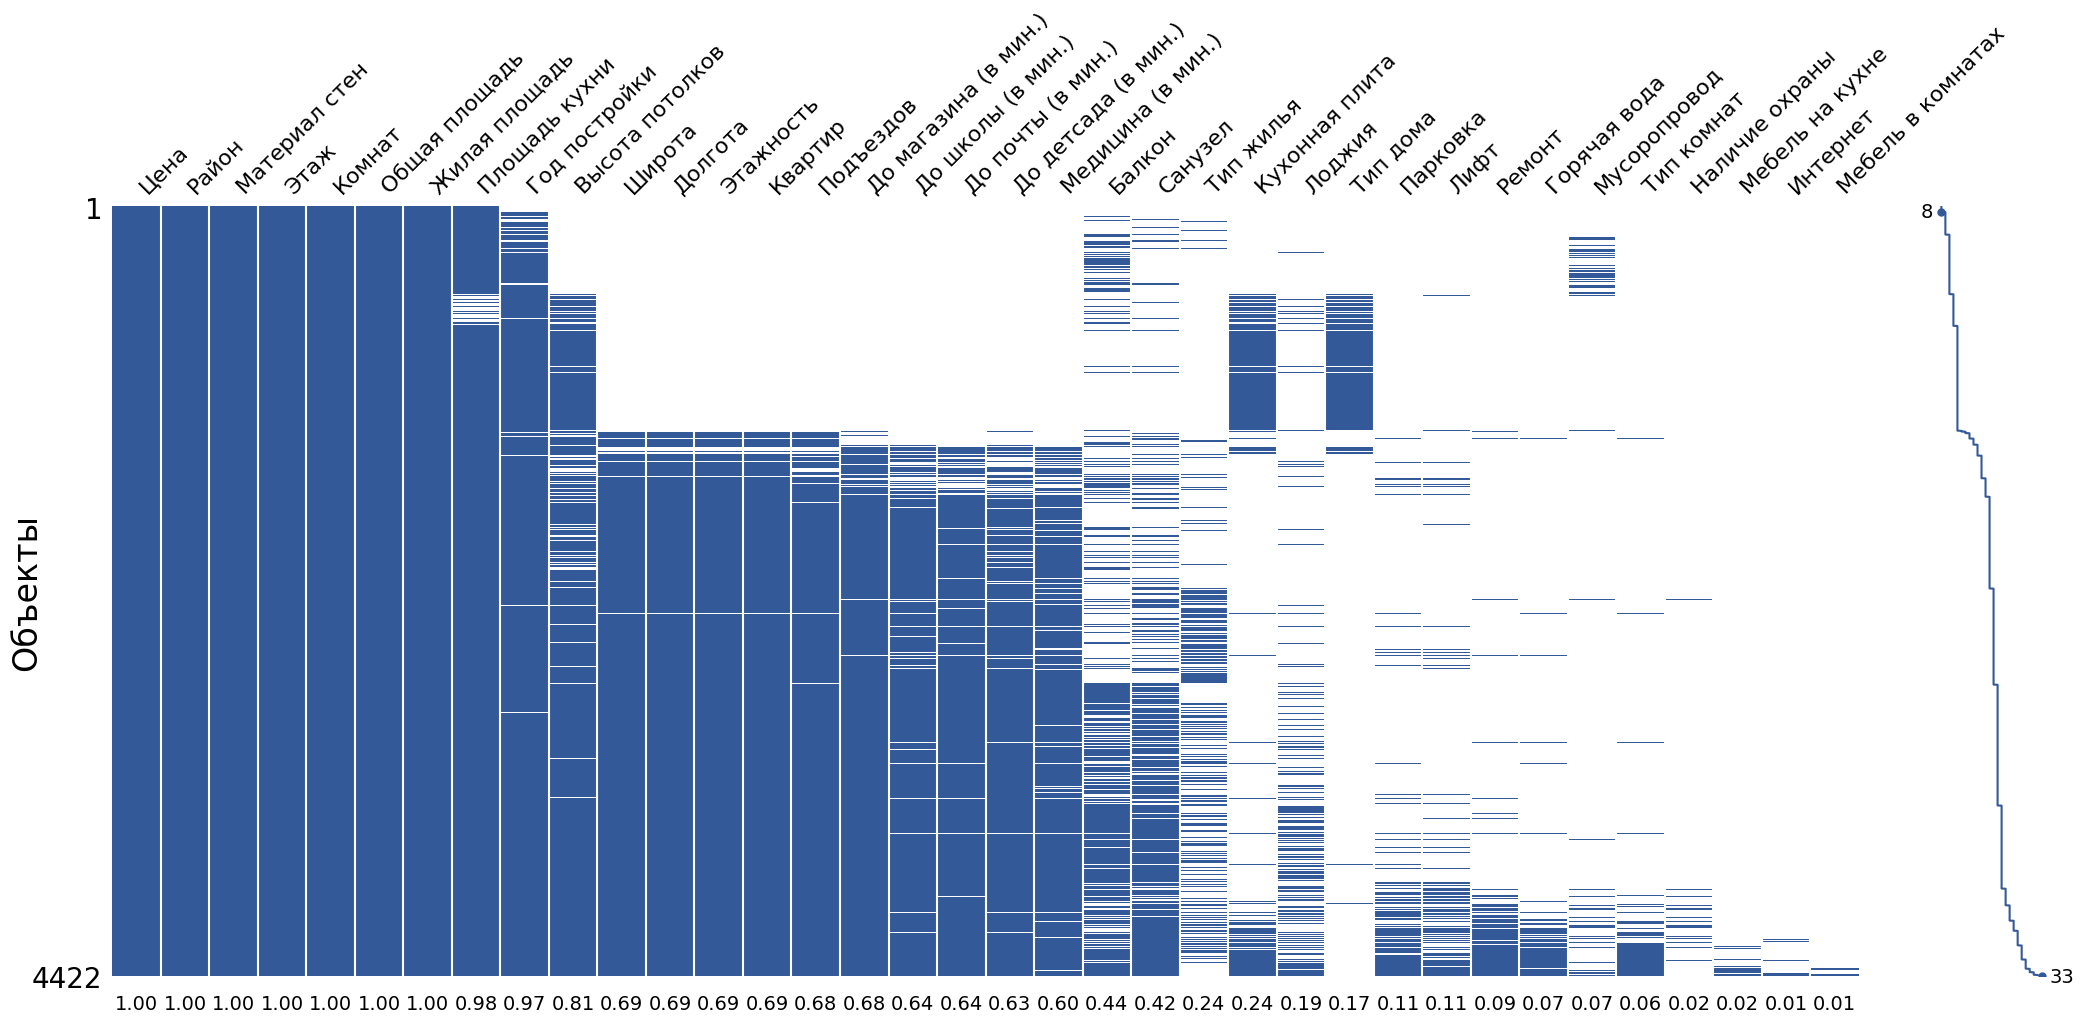

In [11]:
def missing_percentage(series):
    return f'{series.isnull().mean() * 100:.2f}%'

# Создание отсортированного списка столбцов по проценту пропущенных значений
sorted_columns = data.isnull().mean().sort_values().index

# Отображение графика с сортированными столбцами
msno.matrix(
    data[sorted_columns],  # Подаем данные с отсортированными столбцами
    sparkline=True,
    sort="ascending",
    color=(0.2, 0.35, 0.6)
)

# Добавление текста на график для каждого столбца с процентом заполненных значений
for i, column in enumerate(sorted_columns):
    percentage = missing_percentage(data[column])
    plt.text(x=i, y=len(data) + 100, 
             s=f'{((len(data[column]) - data[column].isnull().sum()) / len(data[column])):.2f}', ha='center', va='top', fontsize=14)

# Настройка осей и отображение графика
plt.ylabel('Объекты', ha='center', va='center', fontsize=24)
plt.show()

# Какие данные нам в итоге нужны? Или интеллектуальное удаление строк и столбцов с NaN

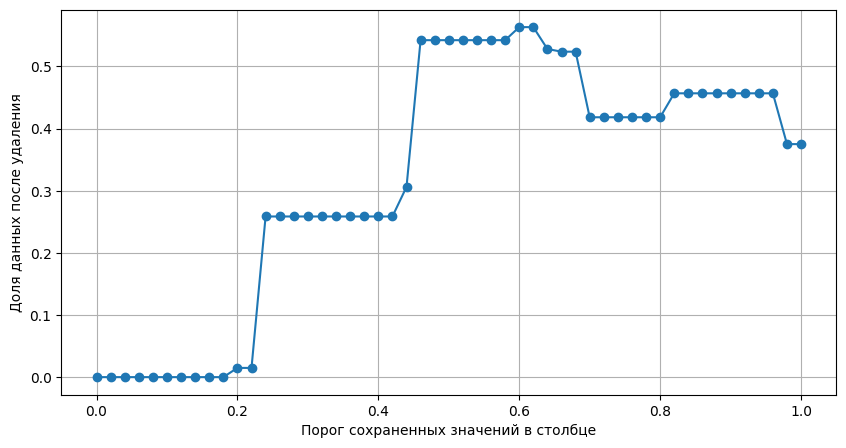

Получившийся порог: 0.6, Оставшиеся данные: 0.56


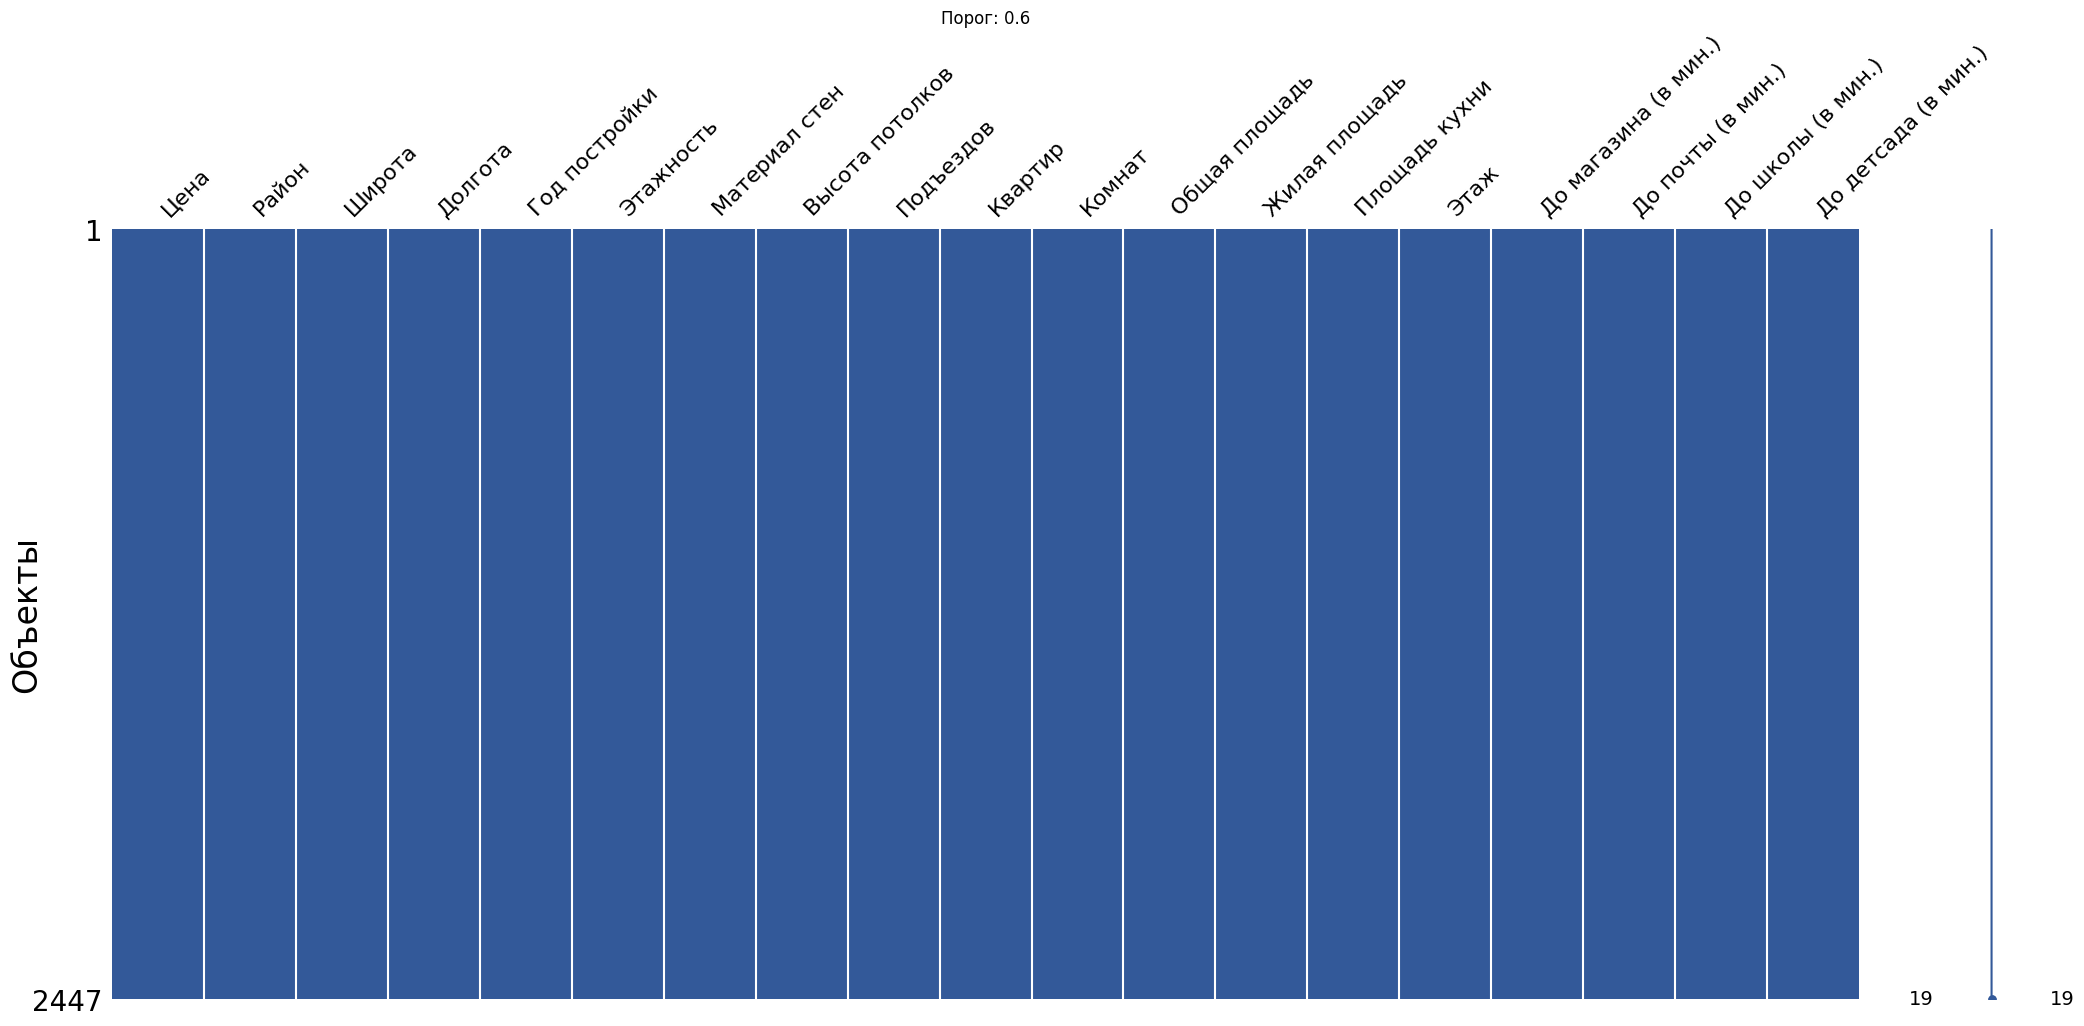

<class 'pandas.core.frame.DataFrame'>
Index: 2447 entries, 0 to 4421
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Цена                  2447 non-null   int64  
 1   Район                 2447 non-null   object 
 2   Широта                2447 non-null   float64
 3   Долгота               2447 non-null   float64
 4   Год постройки         2447 non-null   float64
 5   Этажность             2447 non-null   float64
 6   Материал стен         2447 non-null   object 
 7   Высота потолков       2447 non-null   float64
 8   Подъездов             2447 non-null   float64
 9   Квартир               2447 non-null   float64
 10  Комнат                2447 non-null   int64  
 11  Общая площадь         2447 non-null   float64
 12  Жилая площадь         2447 non-null   float64
 13  Площадь кухни         2447 non-null   float64
 14  Этаж                  2447 non-null   int64  
 15  До магазина (в мин.)  2447

In [12]:
count_data = 0
for col in data.columns:
    count_data += data[col].shape[0] - data[col].isnull().sum()
# print(f'Original amount not NaN fields: {count_data}')   

thresholds = [i/100 for i in range(0, 101, 2)]  # от 0 до 1 с шагом 0.02

saved_fields = []

# Перебираем пороги и вычисляем общие потери данных
for threshold in thresholds:
    threshold_value = len(data) * threshold
    data_filtered = data.dropna(axis='columns', thresh=threshold_value).copy()
    data_filtered.dropna(inplace=True)

    count_data_filtered = 0
    for col in data_filtered.columns:
        count_data_filtered += data_filtered[col].shape[0] - data_filtered[col].isnull().sum()
    # print(f'{threshold}: {data_filtered.shape[1]} призн., {count_data_filtered} не NaNов')

    saved_fields.append(count_data_filtered / count_data)
    
# Строим график
plt.figure(figsize=(10, 5))

plt.plot(thresholds, saved_fields, marker='o')
plt.xlabel('Порог сохраненных значений в столбце')
plt.ylabel('Доля данных после удаления')
plt.grid(True)
plt.show()

best_threshold = thresholds[saved_fields.index(max(saved_fields))]
# best_threshold = 1
test_data = data.dropna(axis='columns', thresh=len(data) * best_threshold).copy()
test_data.dropna(inplace=True)
print(f'Получившийся порог: {best_threshold}, Оставшиеся данные: {(test_data.shape[0] * test_data.shape[1] / count_data):.2f}')

msno.matrix(test_data, sort="ascending", 
            # color=(0.5, 0.65, 0.8)
            color=(0.2, 0.35, 0.6)
            )
plt.ylabel('Объекты', ha='center', va='center', fontsize=24)
plt.title(f'Порог: {best_threshold}')
plt.show()
test_data.info()

# Преобразование object данных

In [13]:
from sklearn.preprocessing import LabelEncoder
print(test_data['Материал стен'].value_counts(normalize=True) * 100)
mapping = {
    'монолитный железобетон': 'монолит'
}
test_data.replace('Материал стен', mapping, inplace=True)
materials = ["кирпич", "панель", "монолит", "блок", "дерево"]

def label_encode(materials, text):
    for material in materials:
        if material in text:
            return material
    return np.nan
test_data['Материал стен'] = test_data['Материал стен'].apply(lambda x: label_encode(materials, x))

digits_encoder = LabelEncoder()
test_data['Материал стен'] = digits_encoder.fit_transform(test_data['Материал стен'])
pd.DataFrame(list(digits_encoder.classes_), columns=['Материал стен'])

Материал стен
кирпич                    43.686146
панель                    35.308541
блок                      17.245607
шлакоблок                  2.819779
монолитный железобетон     0.286065
керамический блок          0.245198
кирпич, панель             0.204332
панель, кирпич             0.122599
дерево                     0.081733
Name: proportion, dtype: float64


,Материал стен
0,блок
1,дерево
2,кирпич
3,монолит
4,панель


In [14]:
district_encoder = LabelEncoder() # он хранит, как распределил data. Другой массив оцифрует так же, а не по порядку, как если бы был новый
test_data['Район'] = district_encoder.fit_transform(test_data['Район'])
pd.DataFrame(list(district_encoder.classes_), columns=['Район'])

,Район
0,Автозаводский
1,Канавинский
2,Ленинский
3,Московский
4,Нижегородский
5,Приокский
6,Советский
7,Сормовский


In [15]:
# KNN
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import MinMaxScaler
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# def median_absolute_percentage_error(y_true, y_pred):
#     absolute_percentage_errors = np.abs((y_true - y_pred) / y_true)
#     return np.median(absolute_percentage_errors) * 100

# neiborses = [i for i in range(1, 16)]
# MDAPE_train = []
# MDAPE_test = []
# R2_train = []
# R2_test = []

# MDAPE_train_std = []
# MDAPE_test_std = []
# R2_train_std = []
# R2_test_std = []

# for neibors in tqdm(neiborses):
#     X = test_data.drop(['Цена'], axis=1)
#     y = test_data['Цена']

#     scaler = MinMaxScaler()
#     scaler.fit(X)
#     X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)
    
#     MDAPE_train_list = []
#     MDAPE_test_list = []
#     R2_train_list = []
#     R2_test_list = []
    
#     for rs in range(1000):
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
# #
#         model = KNeighborsRegressor(n_neighbors=neibors)
#         model.fit(X_train, y_train)

#         y_train_predict = model.predict(X_train)
#         y_test_predict = model.predict(X_test)

#         MDAPE_train_list.append(median_absolute_percentage_error(y_train, y_train_predict))
#         MDAPE_test_list.append(median_absolute_percentage_error(y_test, y_test_predict))
#         R2_train_list.append(r2_score(y_train, y_train_predict))
#         R2_test_list.append(r2_score(y_test,  y_test_predict))
    
    
#     MDAPE_train.append(np.mean(MDAPE_train_list))
#     MDAPE_test.append(np.mean(MDAPE_test_list))
#     MDAPE_train_std.append(np.std(MDAPE_train_list))
#     MDAPE_test_std.append(np.std(MDAPE_test_list))
#     R2_train.append(np.mean(R2_train_list))
#     R2_test.append(np.mean(R2_test_list))
#     R2_train_std.append(np.std(R2_train_list))
#     R2_test_std.append(np.std(R2_test_list))
        
# # # Строим график MDaPE с дисперсиями
# # plt.figure(figsize=(10, 6))
# # plt.errorbar(neiborses, MDAPE_train, yerr=MDAPE_train_std, label='Train MDaPE', fmt='-o', capsize=5)
# # plt.errorbar(neiborses, MDAPE_test, yerr=MDAPE_test_std, label='Test MDaPE', fmt='-o', capsize=5)
# # plt.title(f'KNN, 0.3')
# # plt.xlabel('Колличество соседей')
# # plt.ylabel('MDAPE')
# # plt.grid(True)
# # # plt.ylim(5, 20)
# # plt.show()

# # Строим график R2 с дисперсиями
# plt.figure(figsize=(10, 6))
# plt.errorbar(neiborses, R2_train, yerr=R2_train_std, label='Тренировочная\nвыборка', fmt='-o', capsize=5)
# plt.errorbar(neiborses, R2_test, yerr=R2_test_std, label='Тестовая\nвыборка', fmt='-o', capsize=5)
# # plt.title(f'Зависимость R2 от Колличества соседей\nпри машинном обучении методом ближайших соседей')
# plt.xlabel('Колличество соседей')
# plt.ylabel('R2')
# plt.xticks(neiborses)
# plt.yticks([0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1])
# plt.grid(True)
# plt.legend()
# plt.show()

In [16]:
X = test_data.drop(['Цена'], axis=1)
y = test_data['Цена']

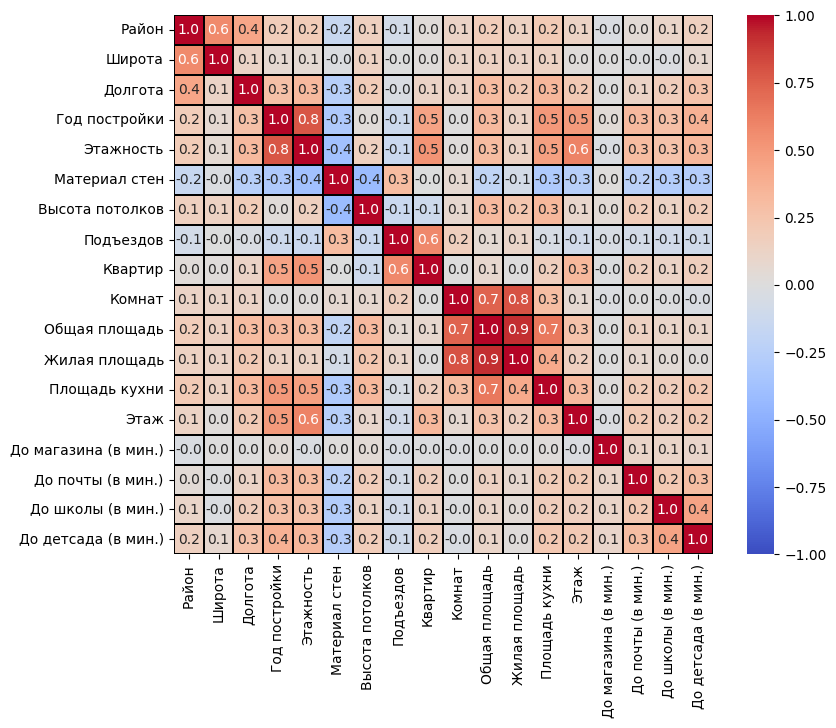

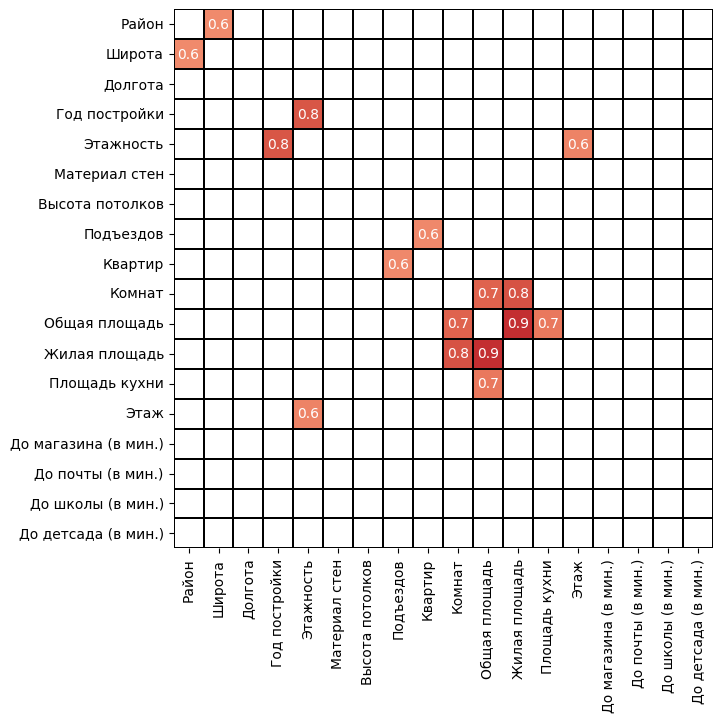

In [17]:
plt.figure(figsize=(9, 7))
corr_mat = X.corr(numeric_only=True)
sns.heatmap(corr_mat, square=True, annot=True, fmt='.1f', vmin=-1, vmax=1
             , cmap='coolwarm', linewidths=0.05, linecolor='black'
            )
plt.show()

plt.figure(figsize=(9, 7))
corr_mat = X.corr(numeric_only=True)

# Установка условий для аннотаций
mask = (np.abs(corr_mat) > 0.55) & (np.abs(corr_mat) < 1)

# Отображение тепловой карты с условиями для аннотаций и диапазоном значений для цветовой шкалы
sns.heatmap(corr_mat, square=True, annot=True, fmt='.1f', vmin=-1, vmax=1,
             cmap='coolwarm', linewidths=0.05, linecolor='black', cbar=False, center=0, mask=~mask)
plt.show()

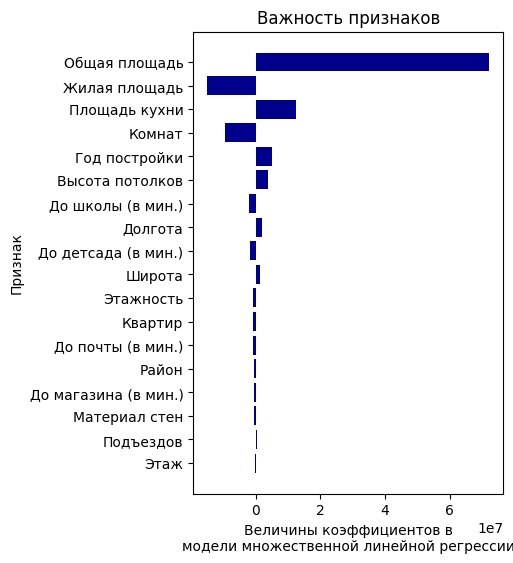

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     314.9
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        09:33:07   Log-Likelihood:                -40573.
No. Observations:                2447   AIC:                         8.118e+04
Df Residuals:                    2428   BIC:                         8.129e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4.003e+06 

In [18]:
# Для линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
test_X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

model = LinearRegression()
model.fit(test_X, y)

# Коэффициенты признаков
coefficients = model.coef_
feature_importance = pd.DataFrame({'Feature': test_X.columns, 'Importance': coefficients})

# Создание объекта для построения графика
plt.figure(figsize=(4, 6))

sorted_feature_importance = feature_importance.iloc[(np.abs(feature_importance['Importance'].values)).argsort()]
# Построение графика
plt.barh(sorted_feature_importance['Feature'], sorted_feature_importance['Importance'], color='darkblue')

# Настройка осей и заголовка
plt.xlabel('Величины коэффициентов в\nмодели множественной линейной регрессии')
plt.ylabel('Признак')
plt.title('Важность признаков')

# Отображение графика
plt.show()


import statsmodels.api as sm
# Добавление столбца с единицами для учета свободного члена (intercept)
test_X_sm = sm.add_constant(test_X)

# Создание и обучение модели
model_sm = sm.OLS(y, test_X_sm).fit()

# Вывод результатов модели
print(model_sm.summary())

In [19]:
test_data.drop(columns=['Район', 'Материал стен', 'Высота потолков', 'Подъездов', 'Квартир', 'Этаж', 'До магазина (в мин.)', 'До почты (в мин.)'], inplace=True) # BEST (исключение из исходных)
test_data.drop(columns=['Комнат', 'Жилая площадь', 'Площадь кухни', 'До школы (в мин.)', 'До детсада (в мин.)'], inplace=True) # BEST (исключение из исходных)

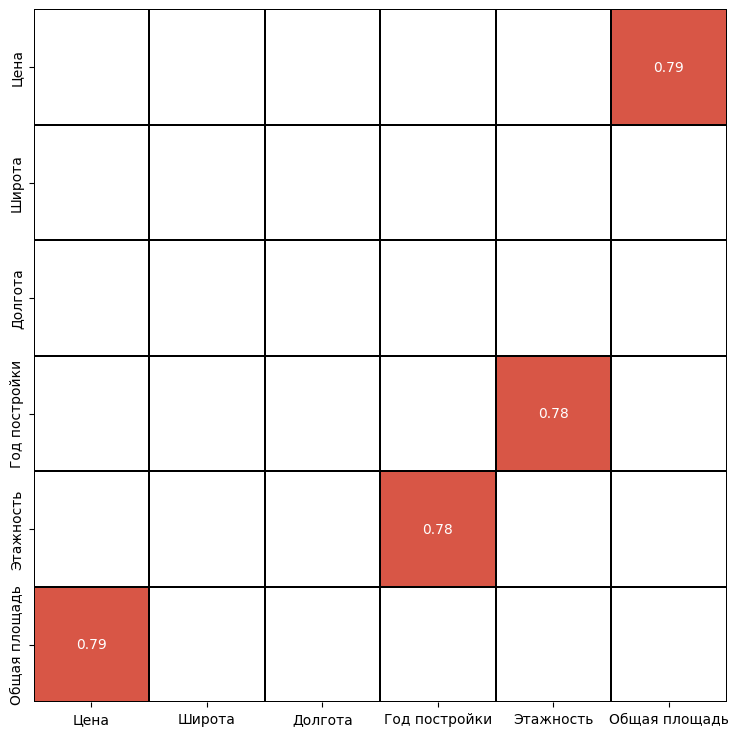

In [20]:
plt.figure(figsize=(12, 9))
corr_mat = test_data.corr(numeric_only=True)

# Установка условий для аннотаций
mask = (np.abs(corr_mat) > 0.49) & (np.abs(corr_mat) < 1)

# Отображение тепловой карты с условиями для аннотаций и диапазоном значений для цветовой шкалы
sns.heatmap(corr_mat, square=True, annot=True, fmt='.2f', vmin=-1, vmax=1,
             cmap='coolwarm', linewidths=0.05, linecolor='black', cbar=False, center=0, mask=~mask)
plt.show()

In [21]:
# KNN
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import MinMaxScaler
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# def median_absolute_percentage_error(y_true, y_pred):
#     absolute_percentage_errors = np.abs((y_true - y_pred) / y_true)
#     return np.median(absolute_percentage_errors) * 100

# neiborses = [i for i in range(1, 16)]
# MDAPE_train = []
# MDAPE_test = []
# R2_train = []
# R2_test = []

# MDAPE_train_std = []
# MDAPE_test_std = []
# R2_train_std = []
# R2_test_std = []

# for neibors in tqdm(neiborses):
#     X = test_data.drop(['Цена'], axis=1)
#     y = test_data['Цена']

#     scaler = MinMaxScaler()
#     scaler.fit(X)
#     X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)
    
#     MDAPE_train_list = []
#     MDAPE_test_list = []
#     R2_train_list = []
#     R2_test_list = []
    
#     for rs in range(1000):
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
# #
#         model = KNeighborsRegressor(n_neighbors=neibors)
#         model.fit(X_train, y_train)

#         y_train_predict = model.predict(X_train)
#         y_test_predict = model.predict(X_test)

#         MDAPE_train_list.append(median_absolute_percentage_error(y_train, y_train_predict))
#         MDAPE_test_list.append(median_absolute_percentage_error(y_test, y_test_predict))
#         R2_train_list.append(r2_score(y_train, y_train_predict))
#         R2_test_list.append(r2_score(y_test,  y_test_predict))
    
    
#     MDAPE_train.append(np.mean(MDAPE_train_list))
#     MDAPE_test.append(np.mean(MDAPE_test_list))
#     MDAPE_train_std.append(np.std(MDAPE_train_list))
#     MDAPE_test_std.append(np.std(MDAPE_test_list))
#     R2_train.append(np.mean(R2_train_list))
#     R2_test.append(np.mean(R2_test_list))
#     R2_train_std.append(np.std(R2_train_list))
#     R2_test_std.append(np.std(R2_test_list))
        
# # # Строим график MDaPE с дисперсиями
# # plt.figure(figsize=(10, 6))
# # plt.errorbar(neiborses, MDAPE_train, yerr=MDAPE_train_std, label='Train MDaPE', fmt='-o', capsize=5)
# # plt.errorbar(neiborses, MDAPE_test, yerr=MDAPE_test_std, label='Test MDaPE', fmt='-o', capsize=5)
# # plt.title(f'KNN, 0.3')
# # plt.xlabel('Колличество соседей')
# # plt.ylabel('MDAPE')
# # plt.grid(True)
# # # plt.ylim(5, 20)
# # plt.show()

# # Строим график R2 с дисперсиями
# plt.figure(figsize=(10, 6))
# plt.errorbar(neiborses, R2_train, yerr=R2_train_std, label='Тренировочная\nвыборка', fmt='-o', capsize=5)
# plt.errorbar(neiborses, R2_test, yerr=R2_test_std, label='Тестовая\nвыборка', fmt='-o', capsize=5)
# # plt.title(f'Зависимость R2 от Колличества соседей\nпри машинном обучении методом ближайших соседей после преобразований')
# plt.xlabel('Колличество соседей')
# plt.ylabel('R2')
# plt.xticks(neiborses)
# plt.yticks([0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1])
# plt.grid(True)
# plt.legend()
# plt.show()

In [22]:
test_data

,Цена,Широта,Долгота,Год постройки,Этажность,Общая площадь
0,6500000,56.239058,43.864066,1978.0,9.0,43.2
3,2250000,56.225889,43.829518,1959.0,2.0,39.1
4,5700000,56.232413,43.950550,1976.0,12.0,37.3
5,14152000,56.293869,44.109839,2015.0,17.0,122.0
7,5900000,56.336383,43.844349,1962.0,5.0,46.2
...,...,...,...,...,...,...
4412,18800000,56.293942,43.988626,1995.0,10.0,122.0
4413,7300000,56.347571,43.927900,1984.0,9.0,52.0
4415,3470000,56.296008,44.028180,1964.0,2.0,38.2
4420,4480000,56.341529,43.846574,1963.0,5.0,43.2


# Выбросы

In [24]:
# pd.plotting.scatter_matrix(data, figsize = (15, 15))
# pass
# plt.figure(figsize=(10, 10))


# Предположим, что у вас уже есть DataFrame data

# # Определяем количество столбцов в data
# num_columns = len(data.columns)

# # Создаем сетку подграфиков
# fig, axes = plt.subplots(ncols=num_columns, nrows=1, figsize=(15, 5))

# # Проходим по каждому столбцу и создаем боксплот
# for i, column in enumerate(data.columns):
#     sns.boxplot(y=column, data=data, whis=3, ax=axes[i])
#     axes[i].set_title(f'Boxplot for {column}')

# # Отключаем автоматическое расположение осей
# plt.tight_layout()

# # Отображаем графики
# plt.show()

In [25]:
# # удаляем данные по кругу вокруг центра масс
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# data_scaled = scaler.fit_transform(data[['Цена', 'Общая площадь']]) # Масштабирование данных
# center = np.mean(data_scaled, axis=0) # Вычисление центра масс
# distances = np.linalg.norm(data_scaled - center, axis=1) # Вычисление расстояния
# threshold = np.quantile(distances, 0.9935) # Определение порогового значения
# rows_to_drop = data[distances > threshold].index # Удаление выбросов

# highlight_mask = data.index.isin(rows_to_drop)

# # Создание диаграммы рассеяния
# plt.scatter(data['Общая площадь'], data['Цена'], alpha=0.2, label='Данные')
# plt.scatter(data.loc[highlight_mask, 'Общая площадь'], data.loc[highlight_mask, 'Цена'], color='red', alpha=0.5, label='Удаляемые')
# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1e-3)))
# plt.xlabel('Общая площадь (в м²)')
# plt.ylabel('Цена (в тыс.)')
# plt.legend()
# plt.show()

# data = data.drop(rows_to_drop)

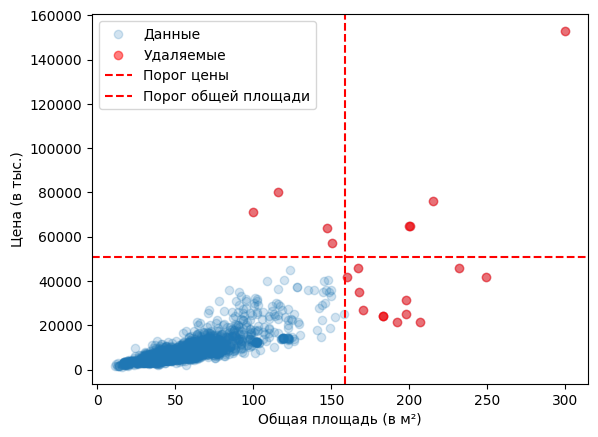

Количество удаленных строк: 20
Количество оставшихся строк: 2427


In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Цена', 'Общая площадь']]) # Масштабирование данных

price_threshold = 50000000
area_threshold = 158

rows_to_drop = data[(data['Цена'] > price_threshold) | (data['Общая площадь'] > area_threshold)].index

highlight_mask = data.index.isin(rows_to_drop)

# Создание диаграммы рассеяния
plt.scatter(data['Общая площадь'], data['Цена'], alpha=0.2, label='Данные')
plt.scatter(data.loc[highlight_mask, 'Общая площадь'], data.loc[highlight_mask, 'Цена'], color='red', alpha=0.5, label='Удаляемые')
# Добавление красных линий
plt.axhline(y=price_threshold + 1000000, color='red', linestyle='--', label='Порог цены')
plt.axvline(x=area_threshold + 1, color='red', linestyle='--', label='Порог общей площади')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1e-3)))
plt.xlabel('Общая площадь (в м²)')
plt.ylabel('Цена (в тыс.)')
plt.legend()
plt.show()

data = data.drop(rows_to_drop)
print(f'Количество удаленных строк: {sum(highlight_mask)}')
print(f'Количество оставшихся строк: {len(data)}')

# Сохраняем только нужные стобца из общей массы

In [27]:
data = data.filter(items=test_data.columns)
data.dropna(axis='rows', inplace=True)

conn = sqlite3.connect('/Users/dima/Desktop/Диплом/Data/best_data.db')
data.to_sql('dataframe', conn, if_exists='replace')
conn.close()

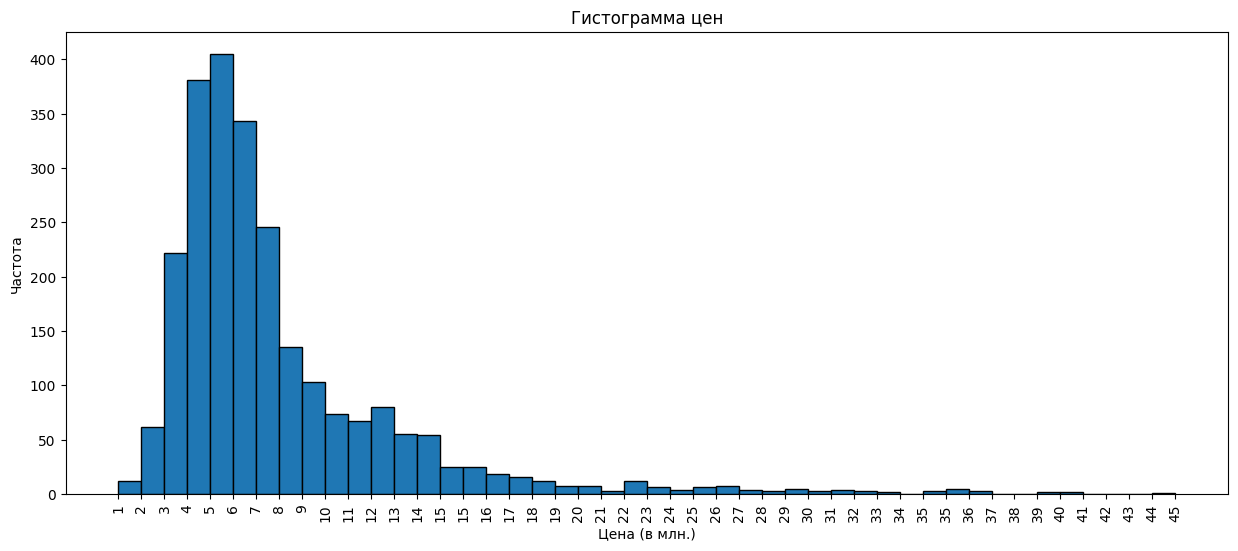

In [28]:
# Построение гистограммы
plt.figure(figsize=(15, 6))
plt.hist(data['Цена'], bins=int(max(data['Цена'] / 1000000 + 1)), edgecolor='black')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1e-6)))
x_ticks = np.linspace(data['Цена'].min(), data['Цена'].max(), num=int(max(data['Цена'] / 1000000+2)))
plt.xticks(x_ticks, rotation=90)
# Настройка параметров графика
plt.xlabel('Цена (в млн.)')
plt.ylabel('Частота')
plt.title('Гистограмма цен')

# Показать гистограмму
plt.show()

31.6


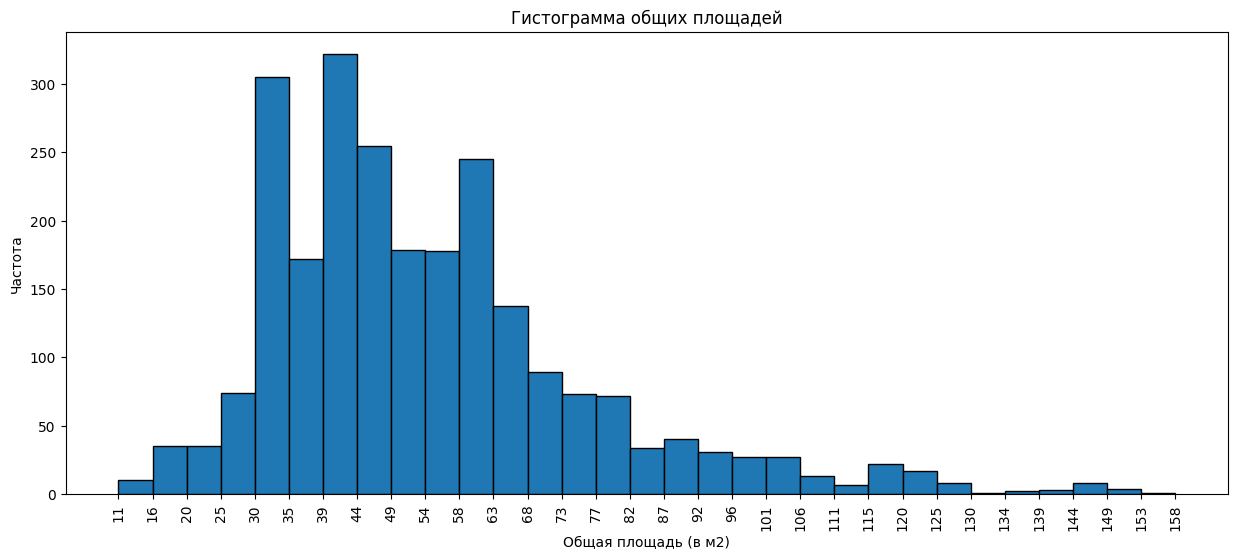

In [29]:
print(max(data['Общая площадь'] / 5))
# Построение гистограммы
plt.figure(figsize=(15, 6))
plt.hist(data['Общая площадь'], bins=int(max(data['Общая площадь'] / 5)), edgecolor='black')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1e-0)))
x_ticks = np.linspace(data['Общая площадь'].min(), data['Общая площадь'].max(), num=int(max(data['Общая площадь'] / 5) + 1))
plt.xticks(x_ticks, rotation=90)
# Настройка параметров графика
plt.xlabel('Общая площадь (в м2)')
plt.ylabel('Частота')
plt.title('Гистограмма общих площадей')

# Показать гистограмму
plt.show()

In [31]:
# # удаляем данные  относительно полиномиальных регрессий
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import MinMaxScaler
# from scipy.stats import zscore

# # Линейная регрессия для предсказания цены на основе общей площади
# X = data[['Общая площадь']]
# y = data['Цена']

# # Преобразование данных в полиномиальные признаки
# poly = PolynomialFeatures(degree=2)
# X_poly = poly.fit_transform(X)

# # Обучение модели линейной регрессии на полиномиальных признаках
# model = LinearRegression()
# model.fit(X_poly, y)
# predictions = model.predict(X_poly)

# # Вычисление остатков (разностей между предсказанными и фактическими значениями)
# residuals = y - predictions

# # Использование Z-оценки для идентификации выбросов
# z_scores = zscore(residuals)
# threshold = 8  # Порог для идентификации выбросов
# outliers = np.abs(z_scores) > threshold

# # Маска для выделения выбросов
# highlight_mask = outliers

# # Создание диаграммы рассеяния с выделенными выбросами
# plt.scatter(data['Общая площадь'], data['Цена'], alpha=0.2, label='Данные')
# plt.scatter(data.loc[highlight_mask, 'Общая площадь'], data.loc[highlight_mask, 'Цена'], color='red', alpha=0.5, label='Удаляемые')

# # Построение трендовой линии
# sorted_index = np.argsort(X['Общая площадь'])
# plt.plot(X.iloc[sorted_index], predictions[sorted_index], color='blue', label='Трендовая линия 1-го порядка')

# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x * 1e-6)))
# plt.xlabel('Общая площадь (в м²)')
# plt.ylabel('Цена (в тыс.)')
# plt.legend()
# plt.show()

# # Удаление выбросов из данных
# data = data[~highlight_mask]

# print(f'Количество удаленных строк: {sum(highlight_mask)}')
# print(f'Количество оставшихся строк: {len(data)}')

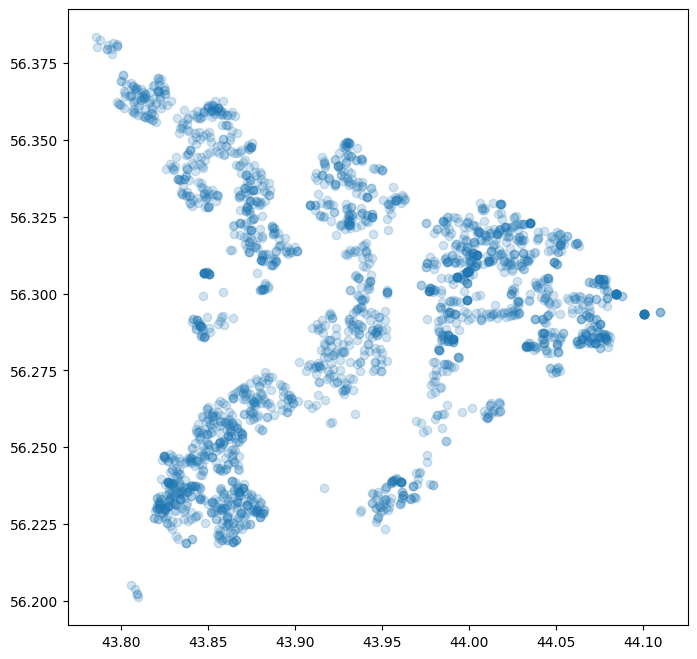

In [32]:
plt.figure(figsize=(8,8))
plt.scatter(data['Долгота'], data['Широта'], alpha=0.2, label='Данные')
plt.show()

In [33]:
num_intervals = 5
intervals = np.linspace(data['Год постройки'].min(), data['Год постройки'].max(), num_intervals + 1)
print(intervals)
qs = []
for i in intervals:
    qs.append(data[data['Год постройки'] < i]['Год постройки'].count() / data['Год постройки'].count())
qs[num_intervals] = 1
print(qs)
# qs = [0, 0.2, 0.4, 0.6, 0.8, 1]
# qs = [0, 0.92, 0.983, 0.997, 0.999, 1]
# qs = [0, 0.5, 0.75, 0.9, 0.99, 1] # красиво для Цен
# qs = [0.0, 0.33, 0.89, 0.982, 0.997, 1] # красиво для Удельных цен
# data.rename(columns={'Удельная цена': 'Цена'}, inplace=True)

import folium
import matplotlib.colors as colors

# Разделение цен на квантильные группы
quantiles = pd.qcut(data['Год постройки'], q=qs, labels=False)

# Создание цветовой карты для квантилей
colors_list = plt.get_cmap('plasma', 5)

# Создание карты с начальной позицией
m = folium.Map(location=[data['Широта'].mean(), data['Долгота'].mean()], zoom_start=12, tiles='CartoDB positron')

# Добавление точек на карту с цветом, зависящим от квантиля
for idx, row in data.iterrows():
    quantile = quantiles[idx]
    color = colors.to_hex(colors_list(quantile))

    popup_info = f'''
    <b>Цена:</b> {row["Цена"]:.0f}<br>
    <b>Широта:</b> {row["Широта"]:.0f}<br>
    <b>Долгота:</b> {row["Долгота"]:.0f}<br>
    <b>Год постройки:</b> {row["Год постройки"]:.0f}<br>
    <b>Этажность:</b> {row["Этажность"]:.0f}<br>
    <b>Общая площадь:</b> {row["Общая площадь"]:.0f}<br>
    '''

    folium.CircleMarker(
        location=[row['Широта'], row['Долгота']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_info, max_width=300)
        # popup=f'Цена: {row["Цена"]}'
    ).add_to(m)

# Добавление легенды
colormap = folium.StepColormap(
    colors=[colors.to_hex(colors_list(i)) for i in range(5)],
    index=[data['Год постройки'].quantile(q) for q in qs],
    vmin=data['Год постройки'].min(), vmax=data['Год постройки'].max(),
    caption='Год постройки'
)
colormap.add_to(m)

# Сохранение карты в HTML файл
m.save('/Users/dima/Desktop/Диплом/Data/floors_map.html')

[1822.  1862.4 1902.8 1943.2 1983.6 2024. ]
[0.0, 0.0008240626287597857, 0.0016481252575195715, 0.03296250515039143, 0.5447053976102184, 1]


In [34]:
# X = data.drop(['Цена'], axis=1)
# y = data['Цена']
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(X)
# X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# from sklearn.neighbors import KNeighborsRegressor

# model = KNeighborsRegressor(n_neighbors=6)
# model.fit(X_train, y_train)
# import joblib

# # Сохранение модели
# joblib.dump(model, '/Users/dima/Desktop/Диплом/Data/knn_model.pkl')

# # Сохранение scaler
# joblib.dump(scaler, '/Users/dima/Desktop/Диплом/Data/scaler.pkl')

# y_train_predict = model.predict(X_train)
# y_test_predict  = model.predict(X_test)

# from sklearn.metrics import mean_squared_error, r2_score

# def median_absolute_percentage_error(y_true, y_pred):
#     absolute_percentage_errors = np.abs((y_true - y_pred) / y_true)
#     return np.median(absolute_percentage_errors) * 100

# knn_metrics = pd.DataFrame(columns=('train', 'test'))

# RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
# RMSE_test  = np.sqrt(mean_squared_error(y_test,  y_test_predict))
# # knn_metrics.loc['RMSE ', :] = (RMSE_train, RMSE_test)

# R2_train = r2_score(y_train, y_train_predict)
# R2_test  = r2_score(y_test,  y_test_predict)
# knn_metrics.loc['R2   ', :] = (R2_train, R2_test)

# MDAPE_train = median_absolute_percentage_error(y_train, y_train_predict)
# MDAPE_test = median_absolute_percentage_error(y_test, y_test_predict)
# # knn_metrics.loc['MDAPE', :] = (MDAPE_train, MDAPE_test)

# print(knn_metrics)

# X_test_original = pd.DataFrame(scaler.inverse_transform(X_test), columns=X.columns, index=X_test.index)

# # Создание DataFrame с тестовыми данными
# test_results = pd.DataFrame(X_test_original, columns=X.columns)

# # Добавление столбца с фактическими ценами
# test_results['Фактическая цена'] = y_test.values

# # Добавление столбца с предсказанными ценами
# test_results['Предсказанная цена'] = y_test_predict

# # Добавление столбца с ошибкой (разница между фактической и предсказанной ценой)
# test_results['Ошибка'] = np.abs((test_results['Фактическая цена'] - test_results['Предсказанная цена'])/test_results['Фактическая цена']
# )
# # Вывод результатов
# conn = sqlite3.connect('/Users/dima/Desktop/Диплом/Data/test_results.db')
# test_results.to_sql('dataframe', conn, if_exists='replace')
# conn.close()

In [35]:
data

,Цена,Широта,Долгота,Год постройки,Этажность,Общая площадь
0,6500000,56.239058,43.864066,1978.0,9.0,43.2
3,2250000,56.225889,43.829518,1959.0,2.0,39.1
4,5700000,56.232413,43.950550,1976.0,12.0,37.3
5,14152000,56.293869,44.109839,2015.0,17.0,122.0
7,5900000,56.336383,43.844349,1962.0,5.0,46.2
...,...,...,...,...,...,...
4412,18800000,56.293942,43.988626,1995.0,10.0,122.0
4413,7300000,56.347571,43.927900,1984.0,9.0,52.0
4415,3470000,56.296008,44.028180,1964.0,2.0,38.2
4420,4480000,56.341529,43.846574,1963.0,5.0,43.2


In [36]:
import folium
import joblib
import matplotlib.colors as colors

model = joblib.load('/Users/dima/Desktop/Диплом/Data/knn_model.pkl')
scaler = joblib.load('/Users/dima/Desktop/Диплом/Data/scaler.pkl')

# Квартира для оценки
new_data = pd.DataFrame({
    'Широта': [56.307934],
    'Долгота': [44.025070],
    'Год постройки': [1973],
    'Этажность': [5],
    'Общая площадь': [63]
})
new_data_scaled = scaler.transform(new_data)

# Предсказание цены
predicted_price = model.predict(new_data_scaled)

print(f'Предсказанная цена: {predicted_price[0]}')

# Найти соседей для нового объекта
distances, indices = model.kneighbors(new_data_scaled)

# Получить соседей из исходного DataFrame
neighbors = data.iloc[indices[0]]

# Визуализация на карте
qs = [0, 0.5, 0.75, 0.9, 0.99, 1]  # Пример квантилей
quantiles = pd.qcut(data['Цена'], q=qs, labels=False)
colors_list = plt.get_cmap('plasma', 5)

# Создание карты с начальной позицией
m = folium.Map(location=[data['Широта'].mean(), data['Долгота'].mean()], zoom_start=12, tiles='CartoDB positron')

# Добавление точек на карту с цветом, зависящим от квантиля
for idx, row in data.iterrows():
    quantile = quantiles[idx]
    color = colors.to_hex(colors_list(quantile))

    popup_info = f'''
    <b>Цена:</b> {row["Цена"]:,.0f}<br>
    <b>Широта:</b> {row["Широта"]:.4f}<br>
    <b>Долгота:</b> {row["Долгота"]:.4f}<br>
    <b>Год постройки:</b> {row["Год постройки"]:.0f}<br>
    <b>Этажность:</b> {row["Этажность"]:.0f}<br>
    <b>Общая площадь:</b> {row["Общая площадь"]:.0f}<br>
    '''
    popup_info = popup_info.replace(",", " ")
    folium.CircleMarker(
        location=[row['Широта'], row['Долгота']],
        radius=2,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_info, max_width=300)
    ).add_to(m)

# Добавление соседей на карту
for idx, row in neighbors.iterrows():
    popup_info = f'''
    <b>Цена:</b> {row["Цена"]:,.0f}<br>
    <b>Широта:</b> {row["Широта"]:.4f}<br>
    <b>Долгота:</b> {row["Долгота"]:.4f}<br>
    <b>Год постройки:</b> {row["Год постройки"]:.0f}<br>
    <b>Этажность:</b> {row["Этажность"]:.0f}<br>
    <b>Общая площадь:</b> {row["Общая площадь"]:.0f}<br>
    '''
    popup_info = popup_info.replace(",", " ")
    folium.CircleMarker(
        location=[row['Широта'], row['Долгота']],
        radius=5,
        color='green',
        fill=True,
        fill_color='lightgreen',
        fill_opacity=0.7,
        popup=folium.Popup(popup_info, max_width=300)
    ).add_to(m)

# Добавление нового объекта на карту
popup_info = f'''
<b>Предсказание:</b> {predicted_price[0]:,.0f}<br>
<b>Широта:</b> {new_data["Широта"].values[0]}<br>
<b>Долгота:</b> {new_data["Долгота"].values[0]}<br>
<b>Год постройки:</b> {new_data["Год постройки"].values[0]}<br>
<b>Этажность:</b> {new_data["Этажность"].values[0]}<br>
<b>Общая площадь:</b> {new_data["Общая площадь"].values[0]}<br>
'''
popup_info = popup_info.replace(",", " ")


folium.Marker(
    location=[new_data['Широта'].values[0], new_data['Долгота'].values[0]],
    popup=folium.Popup(popup_info, max_width=300),
    icon=folium.Icon(color='green')
).add_to(m)

# Добавление легенды
colormap = folium.StepColormap(
    colors=[colors.to_hex(colors_list(i)) for i in range(5)],
    index=[data['Цена'].quantile(q) for q in qs],
    vmin=data['Цена'].min(), vmax=data['Цена'].max(),
    caption='Цена'
)
colormap.add_to(m)

# Сохранение карты в HTML файл
m.save('/Users/dima/Desktop/Диплом/Data/neighbors_map.html')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Предсказанная цена: 7123333.333333333
